In [97]:
import os
import pandas as pd
import numpy as np

In [130]:
df = pd.read_csv('/home/jl277509/Documents/cut_only.csv')

In [131]:
# reshape the df so that keep p is a column
# all and bottom are also in a column
list_extremity=[]
list_proba=[]
list_augmentation=[]
for model in df['model'].tolist():
    if 'all' in model:
        list_extremity.append('All')
    elif 'bottom' in model:
        list_extremity.append('Bottom')
    elif 'no_keep' in model:
        list_extremity.append('Bottom')
        list_proba.append(0)
    if 'p30' in model:
        list_proba.append(30)
    elif 'p50' in model:
        list_proba.append(50)
    elif 'p70' in model:
        list_proba.append(70)
    elif 'p100' in model:
        list_proba.append(100)
    if 'cutin' in model:
        list_augmentation.append('Cutin')
    elif 'cutout' in model:
        list_augmentation.append('Cutout')

In [132]:
df['keep_proba'] = list_proba
df['to_keep']=list_extremity
df['Augmentation']=list_augmentation

In [133]:
#df_simplified = df.drop('model', axis=1)
df_simplified = df.copy()
df_simplified['score']*=100

In [134]:
df_simplified

,model,region,task,score,keep_proba,to_keep,Augmentation
0,10_cutout_keep_all_p30name00-25-11_254,SOr,Left_OFC,59.927480,30,All,Cutout
1,10_cutout_keep_all_p30name04-17-39_7,SOr,Left_OFC,60.735695,30,All,Cutout
2,10_cutout_keep_all_p30name07-07-16_246,SOr,Left_OFC,64.508854,30,All,Cutout
3,10_cutout_keep_all_p30name08-15-46_123,SOr,Left_OFC,63.392129,30,All,Cutout
4,10_cutout_keep_all_p30name11-32-01_176,SOr,Left_OFC,61.030661,30,All,Cutout
...,...,...,...,...,...,...,...
635,4_cutin_keep_all_p70name02-37-51_10,SC-sylv,Isomap_central_left_dim6,42.179307,70,All,Cutin
636,4_cutin_keep_all_p70name06-06-11_239,SC-sylv,Isomap_central_left_dim6,38.846461,70,All,Cutin
637,4_cutin_keep_all_p70name08-00-09_63,SC-sylv,Isomap_central_left_dim6,40.549659,70,All,Cutin
638,4_cutin_keep_all_p70name09-04-24_163,SC-sylv,Isomap_central_left_dim6,41.015227,70,All,Cutin


In [135]:
df_simplified.to_csv('/home/jl277509/Documents/cut_only_simplified.csv')

In [136]:
df = df_simplified.copy()
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
## SIMPLIFY 6 VALUES FOR ISOMAP TO 1 VALUE
# Aggregate the data by averaging 'score' over different 'task' values
df = df.groupby(['model', 'region', 'Augmentation', 'keep_proba', 'to_keep'], as_index=False)['score'].mean()

# Add rows with to_keep='All' where keep_proba=0
additional_rows = df[df['keep_proba'] == 0].copy()
additional_rows['to_keep'] = 'All'
df = pd.concat([df, additional_rows], ignore_index=True)

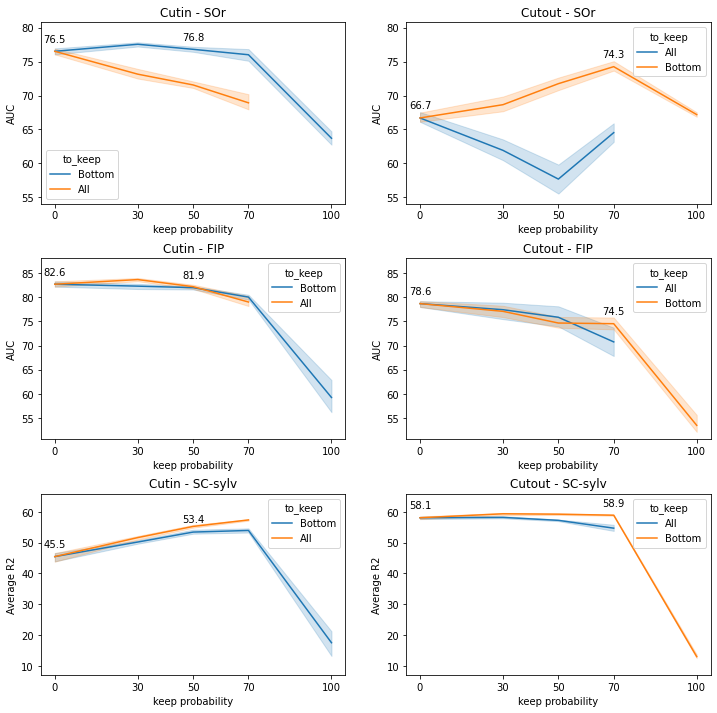

In [156]:
# Define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Define order of rows and columns
regions = ['SOr', 'FIP', 'SC-sylv']
augmentations = ['Cutin', 'Cutout']

# Iterate over regions and augmentations
for row_idx, region in enumerate(regions):
    row_subset = df[df['region'] == region]
    row_min, row_max = row_subset['score'].min(), row_subset['score'].max()
    delta = (row_max - row_min) * 0.12
    row_min, row_max = row_min - delta / 3, row_max + delta
    
    for col_idx, augmentation in enumerate(augmentations):
        ax = axes[row_idx, col_idx]
        
        # Filter data for the subplot
        subset = row_subset[row_subset['Augmentation'] == augmentation]
        
        # Invert the drawing style for 'all' and 'bottom' in the second column
        hue_order = ['Bottom', 'All']
        
        # Plot each curve based on 'to_keep'
        sns.lineplot(
            data=subset, 
            x='keep_proba', 
            y='score', 
            hue='to_keep', 
            estimator='mean',
            markers=True, 
            hue_order=hue_order,
            ax=ax
        )

        # Set x-axis ticks
        ax.set_xticks([0, 30, 50, 70, 100])
        
        # Set title and labels
        ax.set_title(f"{augmentation} - {region}")
        ax.set_xlabel("keep probability")
        if row_idx < 2:
            ax.set_ylabel("AUC")
        elif row_idx == 2:
            ax.set_ylabel('Average R2')
        
        # Adjust y-axis limits per row
        ax.set_ylim([row_min, row_max])

        # Add text annotations for specific points
        highlight_points = [0, 50] if col_idx == 0 else [0, 70]
        subset_mean = subset.groupby(['region','Augmentation', 'keep_proba', 'to_keep'], as_index=False)['score'].mean()
        for _, row in subset_mean[(subset_mean['to_keep'] == 'Bottom') & (subset_mean['keep_proba'].isin(highlight_points))].iterrows():
            ax.text(row['keep_proba'], row['score'] + delta / 2, f"{row['score']:.1f}", 
                    ha='center', fontsize=10, color='black')

# Show legend only in the top-left subplot
axes[0, 0].legend(title="To Keep")
for i in range(3):
    for j in range(2):
        if (i, j) != (0, 0):
            axes[i, j].get_legend().remove()

plt.show()

cutin : peut-être qu'un cutin plus large fonctionnerait aussi ? Même sans garder les bottoms.

In [153]:
df[(df['model'].str.contains('10_cutout')) & (df['region']=='SC-sylv')]['score']

0     57.820661
3     58.873939
6     57.935147
9     58.353083
12    57.909453
Name: score, dtype: float64

In [143]:
df

,model,region,Augmentation,keep_proba,to_keep,score
0,10_cutout_keep_all_p30name00-08-21_0,SC-sylv,Cutout,30,All,57.820661
1,10_cutout_keep_all_p30name00-25-11_254,SOr,Cutout,30,All,59.927480
2,10_cutout_keep_all_p30name04-08-17_213,FIP,Cutout,30,All,77.189429
3,10_cutout_keep_all_p30name04-17-24_159,SC-sylv,Cutout,30,All,58.873939
4,10_cutout_keep_all_p30name04-17-39_7,SOr,Cutout,30,All,60.735695
...,...,...,...,...,...,...
265,9_cutout_no_keepname09-12-49_92,SC-sylv,Cutout,0,All,58.572362
266,9_cutout_no_keepname09-14-43_161,SOr,Cutout,0,All,66.690708
267,9_cutout_no_keepname14-30-00_120,SC-sylv,Cutout,0,All,57.322262
268,9_cutout_no_keepname14-30-00_220,SOr,Cutout,0,All,66.061492


In [125]:
df

,model,region,Augmentation,keep_proba,to_keep,score
0,10_cutout_keep_all_p30name00-08-21_0,SC-sylv,Cutout,30,All,0.578207
1,10_cutout_keep_all_p30name00-25-11_254,SOr,Cutout,30,All,0.599275
2,10_cutout_keep_all_p30name04-08-17_213,FIP,Cutout,30,All,0.771894
3,10_cutout_keep_all_p30name04-17-24_159,SC-sylv,Cutout,30,All,0.588739
4,10_cutout_keep_all_p30name04-17-39_7,SOr,Cutout,30,All,0.607357
...,...,...,...,...,...,...
265,9_cutout_no_keepname09-12-49_92,SC-sylv,Cutout,0,All,0.585724
266,9_cutout_no_keepname09-14-43_161,SOr,Cutout,0,All,0.666907
267,9_cutout_no_keepname14-30-00_120,SC-sylv,Cutout,0,All,0.573223
268,9_cutout_no_keepname14-30-00_220,SOr,Cutout,0,All,0.660615


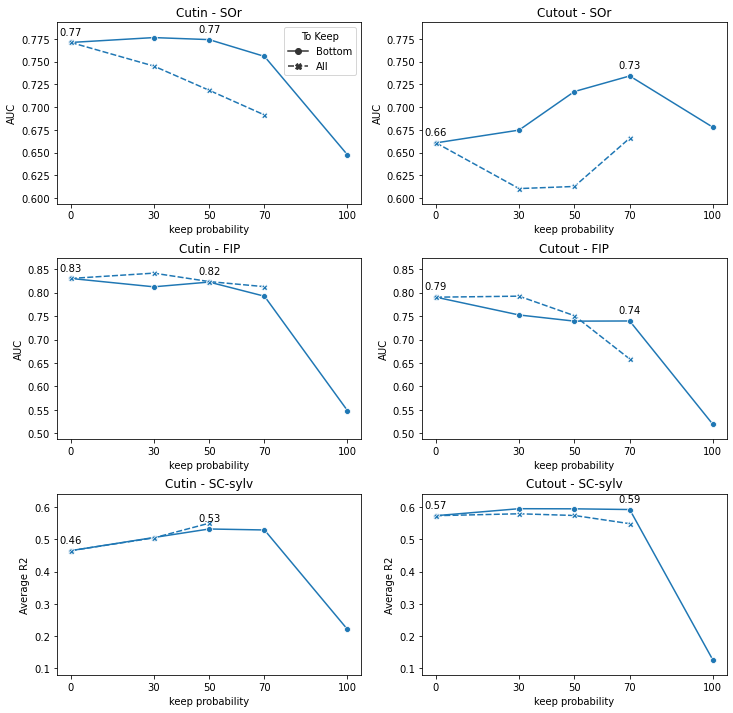

keep -> Protect ?

In [65]:
df_isomap = df_simplified.copy()
df_isomap = df_isomap.loc[df_isomap['region']=='SC-sylv']
df = df_isomap.copy()

In [66]:
df_isomap

,region,task,score,keep_proba,to_keep,Augmentation
32,SC-sylv,Isomap_central_left_dim1,0.641920,30,All,Cutout
33,SC-sylv,Isomap_central_left_dim1,0.629730,50,All,Cutout
34,SC-sylv,Isomap_central_left_dim1,0.598578,70,All,Cutout
35,SC-sylv,Isomap_central_left_dim1,0.665193,30,Bottom,Cutout
36,SC-sylv,Isomap_central_left_dim1,0.662016,50,Bottom,Cutout
...,...,...,...,...,...,...
123,SC-sylv,Isomap_central_left_dim6,0.323369,50,Bottom,Cutin
124,SC-sylv,Isomap_central_left_dim6,0.317472,70,Bottom,Cutin
125,SC-sylv,Isomap_central_left_dim6,0.150262,100,Bottom,Cutin
126,SC-sylv,Isomap_central_left_dim6,0.402273,0,Bottom,Cutout


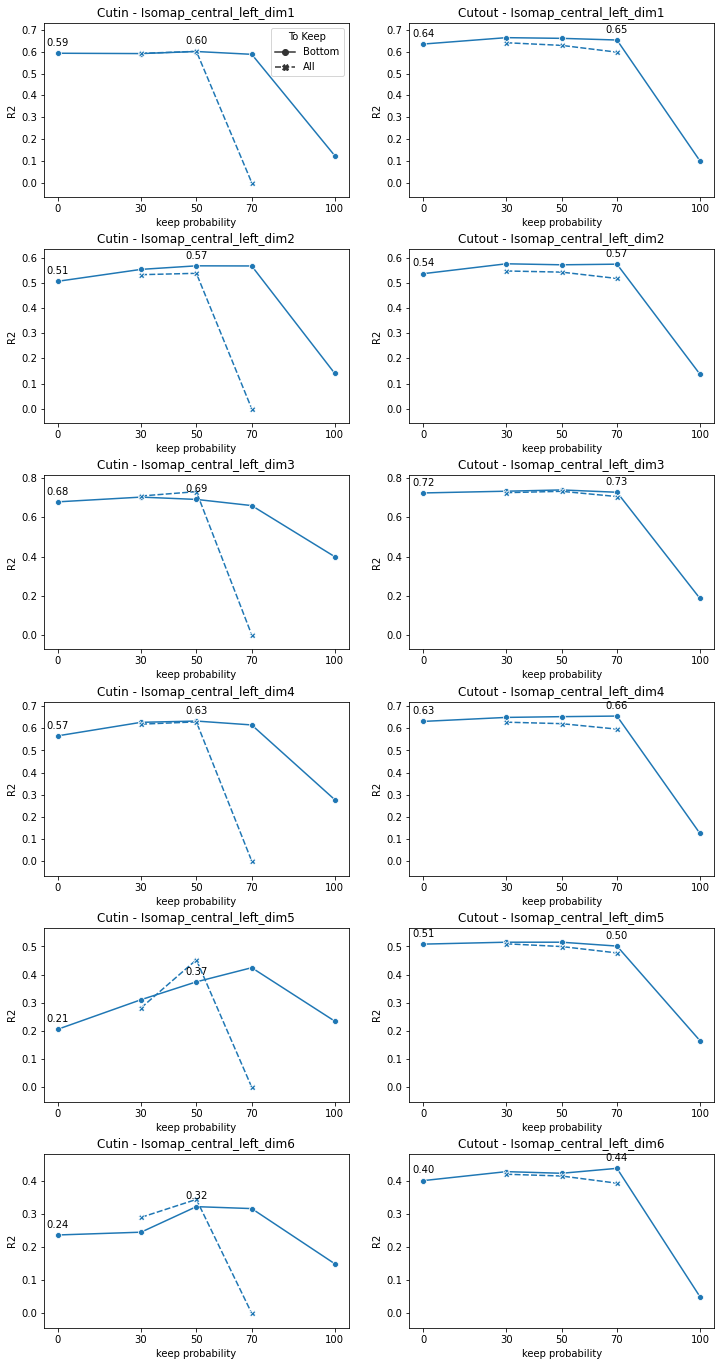

In [70]:
# Define subplot layout
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 24), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Define order of rows and columns
tasks = [f'Isomap_central_left_dim{k}' for k in range(1,7)]
augmentations = ['Cutin', 'Cutout']

# Iterate over tasks and augmentations
for row_idx, task in enumerate(tasks):
    row_subset = df[df['task'] == task]
    row_min, row_max = row_subset['score'].min(), row_subset['score'].max()
    delta = (row_max - row_min) * 0.1
    row_min, row_max = row_min - delta, row_max + delta
    
    for col_idx, augmentation in enumerate(augmentations):
        ax = axes[row_idx, col_idx]
        
        # Filter data for the subplot
        subset = row_subset[row_subset['Augmentation'] == augmentation]
        
        # Invert the drawing style for 'all' and 'bottom' in the second column
        style_order = ['Bottom', 'All']
        
        # Plot each curve based on 'to_keep'
        sns.lineplot(
            data=subset, 
            x='keep_proba', 
            y='score', 
            style='to_keep', 
            markers=True, 
            style_order=style_order,
            ax=ax
        )

        # Set x-axis ticks
        ax.set_xticks([0, 30, 50, 70, 100])
        
        # Set title and labels
        ax.set_title(f"{augmentation} - {task}")
        ax.set_xlabel("keep probability")
        ax.set_ylabel('R2')
        
        # Adjust y-axis limits per row
        ax.set_ylim([row_min, row_max])

        # Add text annotations for specific points
        highlight_points = [0, 50] if col_idx == 0 else [0, 70]
        for _, row in subset[(subset['to_keep'] == 'Bottom') & (subset['keep_proba'].isin(highlight_points))].iterrows():
            ax.text(row['keep_proba'], row['score'] + delta / 2, f"{row['score']:.2f}", 
                    ha='center', fontsize=10, color='black')

# Show legend only in the top-left subplot
axes[0, 0].legend(title="To Keep")
for i in range(6):
    for j in range(2):
        if (i, j) != (0, 0):
            axes[i, j].get_legend().remove()

plt.show()